In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import glob

In [27]:
def get_obj_and_img_points(images):
    objpoints = []
    imgpoints = []

    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

    for filename in images:
        img = npimg.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    return objpoints, imgpoints

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def warp_perspective(img):
    offset_perspective = 300
    imshape = img.shape
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[200,imshape[0]],[500, 500], [imshape[1]-500, 500], [imshape[1]-200,imshape[0]]])
    dst = np.float32([[offset_perspective,imshape[0]],[offset_perspective, 0], [imshape[1]-offset_perspective, 0], [imshape[1]-offset_perspective,imshape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [37]:
images = glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/camera_cal/calibration*')

objpoints, imgpoints = get_obj_and_img_points(images)
undistorted = cal_undistort(frame, objpoints, imgpoints)


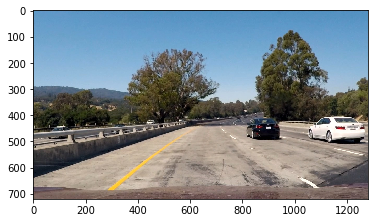

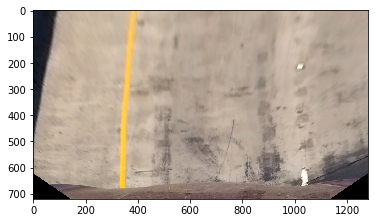

In [28]:
img = npimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/test_images/test1.jpg')


plt.figure(1)
plt.imshow(img)
plt.figure(2)
warp = warp_perspective(img)
plt.imshow(warp)